In [1]:
# !pip install Pillow

In [2]:
# !pip install pytesseract

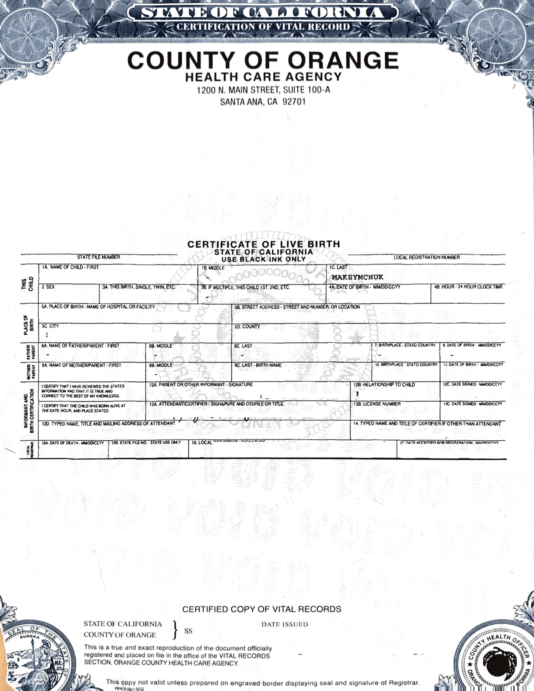

In [3]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("C:/Users/atulp/Desktop/document classifier/test/birth certificate/birth-certificate-sample-usa-534x691 (1).png")
image = image.convert("RGB")
image

We can use the Tesseract OCR engine to turn the image into a list of recognized words:

In [4]:
!cd C:/Program Files/Tesseract-OCR/ &&tesseract --version

tesseract v5.3.1.20230401
 leptonica-1.83.1
  libgif 5.2.1 : libjpeg 8d (libjpeg-turbo 2.1.4) : libpng 1.6.39 : libtiff 4.5.0 : zlib 1.2.13 : libwebp 1.3.0 : libopenjp2 2.5.0
 Found AVX2
 Found AVX
 Found FMA
 Found SSE4.1
 Found libarchive 3.6.2 zlib/1.2.13 liblzma/5.2.9 bz2lib/1.0.8 liblz4/1.9.4 libzstd/1.5.2
 Found libcurl/8.0.1 Schannel zlib/1.2.13 brotli/1.0.9 zstd/1.5.4 libidn2/2.3.4 libpsl/0.21.2 (+libidn2/2.3.3) libssh2/1.10.0


In [5]:
import pytesseract
import numpy as np
pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'
ocr_df = pytesseract.image_to_data(image, output_type='data.frame')

ocr_df = ocr_df.dropna().reset_index(drop=True)
float_cols = ocr_df.select_dtypes('float').columns
ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
words = ' '.join([word for word in ocr_df.text if str(word) != 'nan'])
words





'COUNTY OF ORANGE HEALTH CARE AGENCY 1200 H. MAN STREET, SUE 100-8 SAMIAAA CA 02701'

We can also visualize the bounding boxes of the recognized words, as follows:

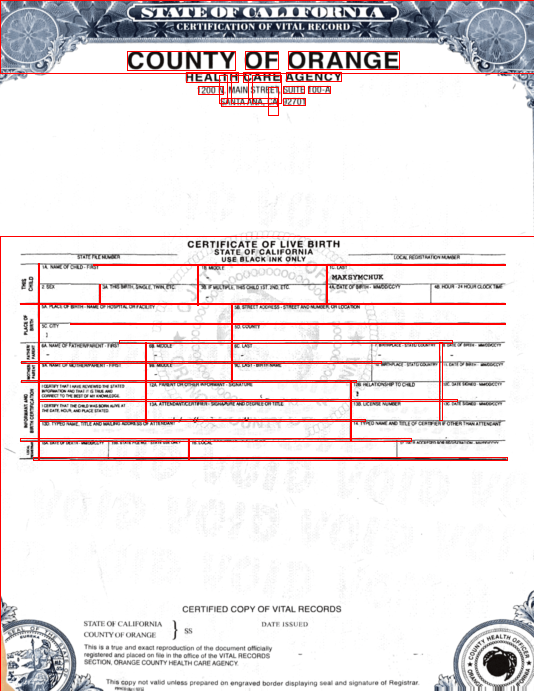

In [6]:
coordinates = ocr_df[['left', 'top', 'width', 'height']]
actual_boxes = []
for idx, row in coordinates.iterrows():
    x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
    actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+width, top+height) to get the actual box 
    actual_boxes.append(actual_box)

draw = ImageDraw.Draw(image, "RGB")
for box in actual_boxes:
  draw.rectangle(box, outline='red')

image

## Preprocessing the data using 🤗 datasets

First, we convert the dataset into a Pandas dataframe, having 2 columns: `image_path` and `label`.

In [7]:
import pandas as pd
import os

dataset_path = "docs_data"
labels = [label for label in os.listdir(dataset_path)]
idx2label = {v: k for v, k in enumerate(labels)}
label2idx = {k: v for v, k in enumerate(labels)}
label2idx

{'birth certificate': 0, 'ssn': 1}

In [8]:
images = []
labels = []

for label_folder, _, file_names in os.walk(dataset_path):
  if label_folder != dataset_path:
    label = label_folder[10:]
    for _, _, image_names in os.walk(label_folder):
      relative_image_names = []
      for image in image_names:
        relative_image_names.append(dataset_path + "/" + label + "/" + image)
      images.extend(relative_image_names)
      labels.extend([label] * len (relative_image_names)) 

data = pd.DataFrame.from_dict({'image_path': images, 'label': labels})
data.head()

,image_path,label
0,docs_data/birth certificate/626c4c52b360b828fc...,birth certificate
1,docs_data/birth certificate/626c4c52b360b828fc...,birth certificate
2,docs_data/birth certificate/626c4c52b360b828fc...,birth certificate
3,docs_data/birth certificate/626c4c52b360b828fc...,birth certificate
4,docs_data/birth certificate/626c4c52b360b828fc...,birth certificate


In [9]:
len(data)

108

Now, let's apply OCR to get the words and bounding boxes of every image. To do this efficiently, we turn our Pandas dataframe into a HuggingFace `Dataset` object, and use the `.map()` functionality to get the words and normalized bounding boxes of every image. Note that this can take a while to run (Tesseract seems a bit slow).

In [10]:
from datasets import Dataset

def normalize_box(box, width, height):
     return [
         int(1000 * (box[0] / width)),
         int(1000 * (box[1] / height)),
         int(1000 * (box[2] / width)),
         int(1000 * (box[3] / height)),
     ]

def apply_ocr(example):
        # get the image
        image = Image.open(example['image_path'])

        width, height = image.size
        
        # apply ocr to the image 
        ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
        float_cols = ocr_df.select_dtypes('float').columns
        ocr_df = ocr_df.dropna().reset_index(drop=True)
        ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
        ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
        ocr_df = ocr_df.dropna().reset_index(drop=True)

        # get the words and actual (unnormalized) bounding boxes
        #words = [word for word in ocr_df.text if str(word) != 'nan'])
        words = list(ocr_df.text)
        words = [str(w) for w in words]
        coordinates = ocr_df[['left', 'top', 'width', 'height']]
        actual_boxes = []
        for idx, row in coordinates.iterrows():
            x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
            actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+width, top+height) to get the actual box 
            actual_boxes.append(actual_box)
        
        # normalize the bounding boxes
        boxes = []
        for box in actual_boxes:
            boxes.append(normalize_box(box, width, height))
        
        # add as extra columns 
        assert len(words) == len(boxes)
        example['words'] = words
        example['bbox'] = boxes
        return example

dataset = Dataset.from_pandas(data)
updated_dataset = dataset.map(apply_ocr)

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

In [11]:
updated_dataset

Dataset({
    features: ['image_path', 'label', 'words', 'bbox'],
    num_rows: 108
})

In [12]:
import pandas as pd
df = pd.DataFrame.from_dict(updated_dataset)
print(len(df["words"][5]))
print(df["words"][5])

15
['COUNTY', 'OF', 'ORANGE', 'HEALTH', 'CARE', 'AGENCY', '1200', 'H.', 'MAN', 'STREET,', 'SUE', '100-8', 'SAMIAAA', 'CA', '02701']


In [13]:
df.head(5)

,image_path,label,words,bbox
0,docs_data/birth certificate/626c4c52b360b828fc...,birth certificate,[],[]
1,docs_data/birth certificate/626c4c52b360b828fc...,birth certificate,[],[]
2,docs_data/birth certificate/626c4c52b360b828fc...,birth certificate,[],[]
3,docs_data/birth certificate/626c4c52b360b828fc...,birth certificate,[],[]
4,docs_data/birth certificate/626c4c52b360b828fc...,birth certificate,[],[]


In [14]:
df = df[df['words'].apply(lambda x: x != [])]
df = df[df['bbox'].apply(lambda x: x != [])]

# Reset the index of the DataFrame
df = df.reset_index(drop=True)

In [15]:
df.head(5)

,image_path,label,words,bbox
0,docs_data/birth certificate/birth-certificate-...,birth certificate,"[COUNTY, OF, ORANGE, HEALTH, CARE, AGENCY, 120...","[[237, 73, 440, 101], [458, 73, 520, 99], [539..."
1,docs_data/birth certificate/birth-certificate-...,birth certificate,"[COUNTY, OF, ORANGE, HEALTH, CARE, AGENCY, 120...","[[237, 73, 440, 101], [458, 73, 520, 99], [539..."
2,docs_data/birth certificate/birth-certificate-...,birth certificate,"[COUNTY, OF, ORANGE, HEALTH, CARE, AGENCY, 120...","[[237, 73, 440, 101], [458, 73, 520, 99], [539..."
3,docs_data/birth certificate/birth-certificate-...,birth certificate,"[COUNTY, OF, ORANGE, HEALTH, CARE, AGENCY, 120...","[[237, 73, 440, 101], [458, 73, 520, 99], [539..."
4,docs_data/birth certificate/birth-certificate-...,birth certificate,"[COUNTY, OF, ORANGE, HEALTH, CARE, AGENCY, 120...","[[237, 73, 440, 101], [458, 73, 520, 99], [539..."


In [16]:
df['label'].unique()

array(['birth certificate', 'ssn'], dtype=object)

Next, we can turn the word-level 'words' and 'bbox' columns into token-level `input_ids`, `attention_mask`, `bbox` and `token_type_ids` using `LayoutLMTokenizer`.

In [17]:
# example

In [33]:
from transformers import LayoutLMTokenizer
import torch

tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")
label2idx = {'birth certificate': 0, 'driving': 1,  'ssn': 3, 'tax document': 4}
def encode_example(example, max_seq_length=512, pad_token_box=[0, 0, 0, 0]):
  words = example['words']
  normalized_word_boxes = example['bbox']

  assert len(words) == len(normalized_word_boxes)

  token_boxes = []
  for word, box in zip(words, normalized_word_boxes):
      word_tokens = tokenizer.tokenize(word)
      token_boxes.extend([box] * len(word_tokens))
  
  # Truncation of token_boxes
  special_tokens_count = 2 
  if len(token_boxes) > max_seq_length - special_tokens_count:
      token_boxes = token_boxes[: (max_seq_length - special_tokens_count)]
  
  # add bounding boxes of cls + sep tokens
  token_boxes = [[0, 0, 0, 0]] + token_boxes + [[1000, 1000, 1000, 1000]]
  
  encoding = tokenizer(' '.join(words), padding='max_length', truncation=True)
  # Padding of token_boxes up the bounding boxes to the sequence length.
  input_ids = tokenizer(' '.join(words), truncation=True)["input_ids"]
  padding_length = max_seq_length - len(input_ids)
  token_boxes += [pad_token_box] * padding_length
  encoding['bbox'] = token_boxes
  encoding['label'] = label2idx.get(example['label'], -1)
#   encoding['label'] = label2idx[example['label']]

  assert len(encoding['input_ids']) == max_seq_length
  assert len(encoding['attention_mask']) == max_seq_length
  assert len(encoding['token_type_ids']) == max_seq_length
  assert len(encoding['bbox']) == max_seq_length

  return encoding

In [34]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D
# we need to define the features ourselves as the bbox of LayoutLM are an extra feature
features = Features({
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'label': ClassLabel(names=['refuted', 'entailed']),
    'image_path': Value(dtype='string'),
    'words': Sequence(feature=Value(dtype='string')),
})



Finally, we set the format to PyTorch, as the LayoutLM implementation in the Transformers library is in PyTorch. We also specify which columns we are going to use.

In [35]:
encoded_dataset = updated_dataset.map( lambda example:encode_example(example)
                                      )
# encoded_dataset = updated_dataset.map(encode_example)

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

In [36]:
encoded_dataset.set_format(type='torch', columns=['input_ids', 'bbox', 'attention_mask', 'token_type_ids', 'label'])

In [37]:
dataloader = torch.utils.data.DataLoader(encoded_dataset, batch_size=1, shuffle=True)
batch = next(iter(dataloader))

Let's verify whether the input ids are created correctly by decoding them back to text:

In [38]:
tokenizer.decode(batch['input_ids'][0].tolist())

'[CLS] 000 - 000 - 0000 this number has bee niestablished for john smith signature [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

In [44]:
# idx2label[batch['label'][0].item()]

## Define the model

Here we define the model, namely `LayoutLMForSequenceClassification`. We initialize it with the weights of the pre-trained base model (`LayoutLMModel`). The weights of the classification head are randomly initialized, and will be fine-tuned together with the weights of the base model on our tiny dataset. Once loaded, we move it to the GPU.



In [40]:
from transformers import LayoutLMForSequenceClassification
import torch
from transformers import logging

logging.set_verbosity_warning()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LayoutLMForSequenceClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=len(label2idx))
model.to(device)

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing LayoutLMForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForSequenceClassification were not initialized from the model checkpoint 

LayoutLMForSequenceClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0-11): 12 x LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True

## Train the model

Here we train the model in familiar PyTorch fashion. We use the Adam optimizer with weight decay fix (normally you can also specify which variables should have weight decay and which not + a learning rate scheduler, see [here](https://github.com/microsoft/unilm/blob/5d16c846bec56b6e88ec7de4fc3ceb7c803571a4/layoutlm/examples/classification/run_classification.py#L94) for how the authors of LayoutLM did this), and train for 30 epochs. If the model is able to overfit it, then it means there are no issues and we can train it on the entire dataset.

In [41]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=4e-5)

global_step = 0
num_train_epochs = 30
t_total = len(dataloader) * num_train_epochs # total number of training steps 

#put the model in training mode
model.train()
for epoch in range(num_train_epochs):
  print("Epoch:", epoch)
  running_loss = 0.0
  correct = 0
  for batch in dataloader:
      input_ids = batch["input_ids"].to(device)
      bbox = batch["bbox"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      token_type_ids = batch["token_type_ids"].to(device)
      labels = batch["label"].to(device)

      # forward pass
      outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                      labels=labels)
      loss = outputs.loss

      running_loss += loss.item()
      predictions = outputs.logits.argmax(-1)
      correct += (predictions == labels).float().sum()

      # backward pass to get the gradients 
      loss.backward()

      # update
      optimizer.step()
      optimizer.zero_grad()
      global_step += 1
  
  print("Loss:", running_loss / batch["input_ids"].shape[0])
  accuracy = 100 * correct / len(data)
  print("Training accuracy:", accuracy.item())

C:\Users\atulp\Desktop\document classifier\layoutclassification\Document-Classification-using-LayoutLM\classifer\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch: 0
Loss: 76.33631526306272
Training accuracy: 67.59259033203125
Epoch: 1
Loss: 32.01036876812577
Training accuracy: 87.96295928955078
Epoch: 2
Loss: 29.353933781851083
Training accuracy: 87.03704071044922
Epoch: 3
Loss: 27.83993356488645
Training accuracy: 89.81481170654297
Epoch: 4
Loss: 27.170519250445068
Training accuracy: 88.88888549804688
Epoch: 5
Loss: 25.698436895152554
Training accuracy: 88.88888549804688
Epoch: 6
Loss: 26.2260320878122
Training accuracy: 89.81481170654297
Epoch: 7
Loss: 27.118842106778175
Training accuracy: 88.88888549804688
Epoch: 8
Loss: 25.109533029375598
Training accuracy: 89.81481170654297
Epoch: 9
Loss: 26.033791795605794
Training accuracy: 88.88888549804688
Epoch: 10
Loss: 27.12027399172075
Training accuracy: 85.18518829345703
Epoch: 11
Loss: 27.411497227381915
Training accuracy: 89.81481170654297
Epoch: 12
Loss: 23.15141513524577
Training accuracy: 89.81481170654297
Epoch: 13
Loss: 24.07608805829659
Training accuracy: 89.81481170654297
Epoch: 14


# Inference

#### NOTE: Check Predictor notebook for Inference from the Saved Model

In [ ]:
# from transformers import LayoutLMTokenizer, LayoutLMForSequenceClassification
# import torch
# tokenizer = LayoutLMTokenizer.from_pretrained('microsoft/layoutlm-base-uncased')
# model = LayoutLMForSequenceClassification.from_pretrained('microsoft/layoutlm-base-uncased')
# words = ["Hello", "world"]
# normalized_word_boxes = [637, 773, 693, 782], [698, 773, 733, 782]
# token_boxes = []
# for word, box in zip(words, normalized_word_boxes):
#     word_tokens = tokenizer.tokenize(word)
#     token_boxes.extend([box] * len(word_tokens))
# # add bounding boxes of cls + sep tokens
# token_boxes = [[0, 0, 0, 0]] + token_boxes + [[1000, 1000, 1000, 1000]]
# encoding = tokenizer(' '.join(words), return_tensors="pt")
# input_ids = encoding["input_ids"]
# attention_mask = encoding["attention_mask"]
# token_type_ids = encoding["token_type_ids"]
# bbox = torch.tensor([token_boxes])
# sequence_label = torch.tensor([1])
# outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
#                 labels=sequence_label)
# loss = outputs.loss
# logits = outputs.logits

# Saving the model

In [43]:
model.save_pretrained('saved_model/')

In [48]:
# model.save_pretrained(layoutverification.h5)

In [47]:
model.save_pretrained('layoutmodel/')